In [1]:
import numpy as np
import json
import geopandas as gpd
import pandas as pd
import xarray as xr
from affine import Affine
import rasterio as rio
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
########## USER ###########
# Select modeling domain ('WY', 'UT', 'OR', 'WA')
domain = 'WY'

# SM location 
SMpath = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhillWY'

# swe file no assim 
swe_base = SMpath + '_cso_id/outputs/wo_assim/swed.gdat'
swe_base_snotel = SMpath + '_snotel/outputs/wi_assim/swed.gdat'
swe_base_cso = SMpath + '_cso_id/outputs/wi_assim/swed.gdat'
# swe file with snotel assim 
# swe_base_snotel = SMpath + 'outputs/wi_assim/swed_SNOTELallD.gdat'
# swe_base_snotel1 = SMpath + 'outputs/wi_assim/swed_SNOTEL.gdat'
# swe_base_cso = SMpath + 'outputs/wi_assim/swed_CSO.gdat'
#swe_base_cso = SMpath + 'outputs/wi_assim/swed.gdat'

#all snotel 
gdf = gpd.read_file('/nfs/attic/dfh/Aragon2/CSOdata/'+domain+'/CSO_SNOTEL_sites.geojson')

#assim snotel
assimPath = '/nfs/attic/dfh/Aragon2/CSOassim/'+domain+'/'
assim_gdf = gpd.read_file(assimPath + 'assim_SNOTEL_sites.geojson')

#path to CSO domain json
with open('/nfs/attic/dfh/Aragon2/CSOdata/CSO_domains.json') as f:
    domains = json.load(f)
    
dem_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/DEM_'+domain+'.tif'
    
#dates
st = '2018-09-01'
ed = '2019-09-30'

# snotel swe 
swe_snotel = pd.read_csv(assimPath + 'SNOTEL_data_SWEDmeters'+st+'_'+ed+'.csv')

num_timesteps =(datetime.strptime(ed,'%Y-%m-%d')-datetime.strptime(st,'%Y-%m-%d')).days+1
                          
nx = int(domains[domain]['ncols'])
ny = int(domains[domain]['nrows'])

In [3]:
gdf

,code,longitude,latitude,name,elevation_m,easting,northing,geometry
0,314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,544505.845453,4.865379e+06,POINT (-110.44544 43.94019)
1,347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,489823.440274,4.928341e+06,POINT (-111.12803 44.50832)
2,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,596129.923439,4.914418e+06,POINT (-109.79333 44.37667)
3,353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,531828.554679,4.756891e+06,POINT (-110.60973 42.96400)
4,419_WY_SNTL,-110.814819,42.645901,Cottonwood Creek,2337.81591796875,515180.157295,4.721511e+06,POINT (-110.81482 42.64590)
5,460_WY_SNTL,-110.202301,43.130970,East Rim Divide,2417.06396484375,564881.001429,4.775668e+06,POINT (-110.20230 43.13097)
6,468_WY_SNTL,-109.758926,43.006569,Elkhart Park G.S.,2865.1201171875,601147.651582,4.762292e+06,POINT (-109.75893 43.00657)
7,1082_WY_SNTL,-110.927834,43.779331,Grand Targhee,2822.447998046875,505807.281569,4.847367e+06,POINT (-110.92783 43.77933)
8,497_WY_SNTL,-110.434952,43.342979,Granite Creek,2063.49609375,545799.195781,4.799058e+06,POINT (-110.43495 43.34298)
9,499_WY_SNTL,-110.834351,44.126122,Grassy Lake,2214.3720703125,513252.629700,4.885894e+06,POINT (-110.83435 44.12612)


In [4]:
# projection
mod_proj = domains[domain]['mod_proj']
new=gdf.to_crs(mod_proj)
new.head()

,code,longitude,latitude,name,elevation_m,easting,northing,geometry
0,314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,544505.845453,4.865379e+06,POINT (544505.845 4865379.298)
1,347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,489823.440274,4.928341e+06,POINT (489823.440 4928341.300)
2,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,596129.923439,4.914418e+06,POINT (596129.923 4914418.231)
3,353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,531828.554679,4.756891e+06,POINT (531828.555 4756891.027)
4,419_WY_SNTL,-110.814819,42.645901,Cottonwood Creek,2337.81591796875,515180.157295,4.721511e+06,POINT (515180.157 4721510.514)


In [5]:
da = xr.open_rasterio(dem_path)
transform = Affine.from_gdal(*da.attrs['transform'])
nx, ny = da.sizes['x'], da.sizes['y']
x, y = np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5) * transform
da

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  after removing the cwd from sys.path.


<xarray.DataArray (band: 1, y: 2476, x: 1382)>
[3421832 values with dtype=int16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.938e+06 4.938e+06 4.937e+06 ... 4.69e+06 4.69e+06
  * x        (x) float64 4.872e+05 4.874e+05 4.874e+05 ... 6.252e+05 6.254e+05
Attributes:
    transform:      (100.0, 0.0, 487200.0, 0.0, -100.0, 4937700.0)
    crs:            +init=epsg:32612
    res:            (100.0, 100.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('elevation',)
    AREA_OR_POINT:  Area

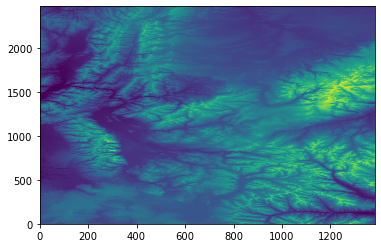

In [6]:
plt.pcolormesh(da[0,:,:])

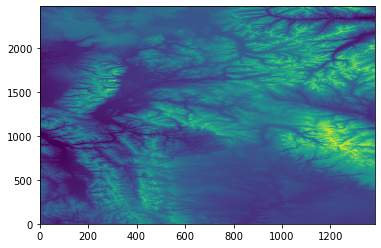

In [7]:
plt.pcolormesh(np.flipud(da[0,:,:]))

### need to get index of station 

In [8]:
#station index
x_idx = []
y_idx = []

for i in range(len(new)):
    minx = abs(new.geometry.x[i]-da.x.values)
    x=np.where(minx==min(abs(new.geometry.x[i]-da.x.values)))[0][0]
    x_idx.append(x)
    # flip y values to align with cartesian coordinates
    miny = abs(new.geometry.y[i]-np.flip(da.y.values))
    y=np.where(miny==min(abs(new.geometry.y[i]-np.flip(da.y.values))))[0][0]
    y_idx.append(y)

    
new['x_idx']=x_idx
new['y_idx']=y_idx
new

,code,longitude,latitude,name,elevation_m,easting,northing,geometry,x_idx,y_idx
0,314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,544505.845453,4.865379e+06,POINT (544505.845 4865379.298),573,1752
1,347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,489823.440274,4.928341e+06,POINT (489823.440 4928341.300),26,2382
2,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,596129.923439,4.914418e+06,POINT (596129.923 4914418.231),1089,2243
3,353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,531828.554679,4.756891e+06,POINT (531828.555 4756891.027),446,667
4,419_WY_SNTL,-110.814819,42.645901,Cottonwood Creek,2337.81591796875,515180.157295,4.721511e+06,POINT (515180.157 4721510.514),279,314
5,460_WY_SNTL,-110.202301,43.130970,East Rim Divide,2417.06396484375,564881.001429,4.775668e+06,POINT (564881.001 4775667.750),776,855
6,468_WY_SNTL,-109.758926,43.006569,Elkhart Park G.S.,2865.1201171875,601147.651582,4.762292e+06,POINT (601147.652 4762291.524),1139,721
7,1082_WY_SNTL,-110.927834,43.779331,Grand Targhee,2822.447998046875,505807.281569,4.847367e+06,POINT (505807.282 4847366.650),186,1572
8,497_WY_SNTL,-110.434952,43.342979,Granite Creek,2063.49609375,545799.195781,4.799058e+06,POINT (545799.196 4799058.232),585,1089
9,499_WY_SNTL,-110.834351,44.126122,Grassy Lake,2214.3720703125,513252.629700,4.885894e+06,POINT (513252.630 4885894.374),260,1957


In [9]:
#function to extract time series at station location
def get_mod_output(inFile,num_timesteps,nx,ny):
    #open the grads model output file, 'rb' indicates reading from binary file
    grads_data = open(inFile,'rb')
    # convert to a numpy array 
    numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
    #close grads file 
    grads_data.close()
    #reshape the data
    numpy_data = np.reshape(numpy_data,(num_timesteps,nx,ny))

    return numpy_data

In [ ]:
SMswe_cso = get_mod_output(swe_base_cso,num_timesteps,ny,nx)
SMswe_snotel = get_mod_output(swe_base_snotel,num_timesteps,ny,nx)
SMswe_base = get_mod_output(swe_base,num_timesteps,ny,nx)

In [ ]:
#plot to check results
plt.pcolormesh(np.squeeze(SMswe_cso[100,:,:]))



In [10]:
def get_swe_timeseries(datacube, y_idx,x_idx):
    data = np.squeeze(datacube[:,y_idx,x_idx])
    return data
    

In [11]:
#compute model performance metrics
def calc_metrics(mod_swe,stn_swe):
    swe_stats = []
    

    #remove days with zero SWE at BOTH the station and the SM pixel
    idx = np.where((stn_swe != 0) | (mod_swe != 0))
    mod_swe = mod_swe[idx]
    stn_swe = stn_swe[idx]

    #remove days where station has nan values 
    idx = np.where(~np.isnan(stn_swe))
    mod_swe = mod_swe[idx]
    stn_swe = stn_swe[idx]

    #R-squared value
    r = np.corrcoef(stn_swe, mod_swe)[0,1]**2
    swe_stats.append(r)

    #mean bias error
    mbe = (sum(mod_swe - stn_swe))/mod_swe.shape[0]
    swe_stats.append(mbe)

    #root mean squared error
    rmse = np.sqrt((sum((mod_swe - stn_swe)**2))/mod_swe.shape[0])
    swe_stats.append(rmse)

    # Nash-Sutcliffe model efficiency coefficient, 1 = perfect, assumes normal data 
    nse_top = sum((mod_swe - stn_swe)**2)
    nse_bot = sum((stn_swe - np.mean(stn_swe))**2)
    nse = 1-(nse_top/nse_bot)
    swe_stats.append(nse)

    # Kling-Gupta Efficiency, 1 = perfect
    kge_std = (np.std(mod_swe)/np.std(stn_swe))
    kge_mean = (np.mean(mod_swe)/np.mean(stn_swe))
    kge_r = np.corrcoef(stn_swe,mod_swe)[1,0]
    kge = 1 - (np.sqrt((kge_r-1)**2)+((kge_std-1)**2)+(kge_mean-1)**2)
    swe_stats.append(kge)
    
    #metT
    mett_L = (1 + np.corrcoef(stn_swe,mod_swe)[1,0])/2
    mse=np.square(mod_swe-stn_swe).mean()
    bias = (np.mean(mod_swe) - np.mean(stn_swe))**2
    sigm = np.std(mod_swe)**2
    sigr = np.std(stn_swe)**2
    met_t = mett_L * (1- (mse)/(bias+sigm+sigr))
    swe_stats.append(met_t)    
        
    return swe_stats



## cross plot

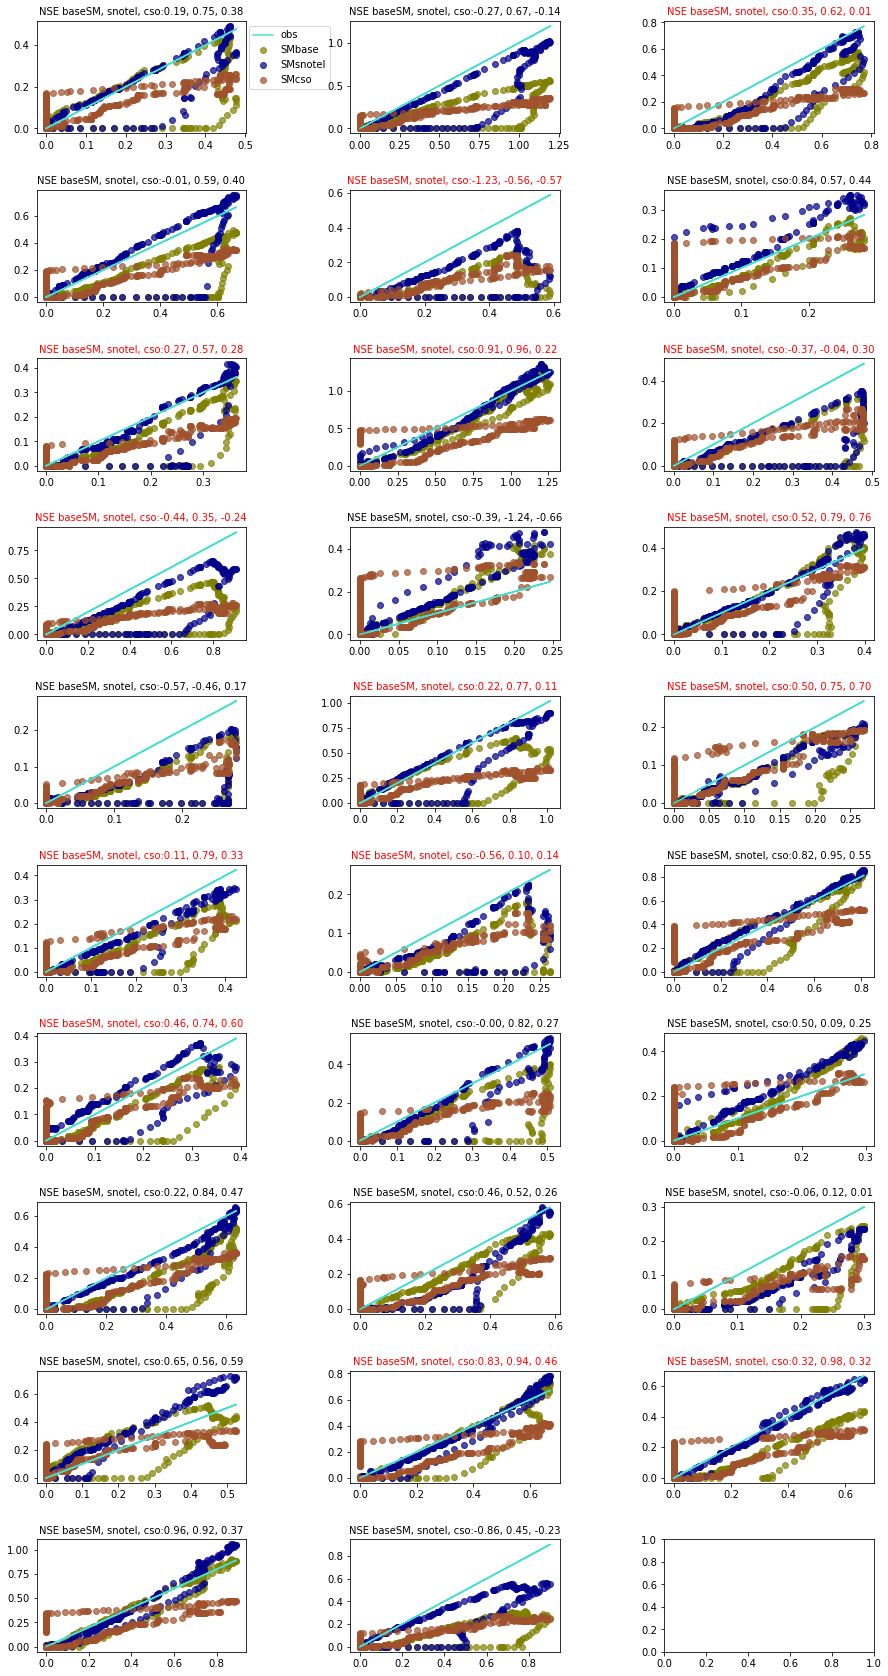

In [19]:
i=0

fig, axs = plt.subplots(nrows=10,figsize=(15, 30), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.flatten()

for i in range(len(new)):
    x_idx = int(new.x_idx[i])
    y_idx = int(new.y_idx[i])
    nam = new.code[i]
    if any(nam in s for s in assim_stn):
        color = 'r'
    else:
        color = 'k'
    swe_mod_cso = np.squeeze(SMswe_cso[:,y_idx,x_idx])/10
    swe_mod_snotel = np.squeeze(SMswe_snotel[:,y_idx,x_idx])
    swe_mod_base = np.squeeze(SMswe_base[:,y_idx,x_idx])
    swe_obs = swe_snotel[nam]
    swe_stats_cso = calc_metrics(swe_mod_cso,swe_obs.values)
    swe_stats_snotel = calc_metrics(swe_mod_snotel,swe_obs.values)
    swe_stats_base = calc_metrics(swe_mod_base,swe_obs.values)
    #     axs[i].text(1.3, .3, 'NSE_baseSM: '+str("{:.2f}".format(swe_stats_base[3]))+'\n'
    #              +'NSE_snotel: '+str("{:.2f}".format(swe_stats_snotel[3]))+'\n'
    #              +'NSE_cso: '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)
    axs[i].plot(swe_obs,swe_obs,label = 'obs', color = 'turquoise')
    axs[i].scatter(swe_obs,swe_mod_base,label='mod_base',color = 'olive',alpha=.7)
    axs[i].scatter(swe_obs,swe_mod_snotel,label='mod_snotel',color = 'darkblue',alpha=.7)
    axs[i].scatter(swe_obs,swe_mod_cso,label='mod_cso',color = 'sienna',alpha=.7)
    axs[i].set_title('NSE baseSM, snotel, cso:'+str("{:.2f}".format(swe_stats_base[3]))
             +', '+str("{:.2f}".format(swe_stats_snotel[3]))
             +', '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)
    #axs[i].set_ylim([0, 1.6])
    if i == 0:
        axs[i].legend(['obs', 'SMbase','SMsnotel','SMcso'],bbox_to_anchor=(.99, 1), loc='upper left',)  

## timeseries plot

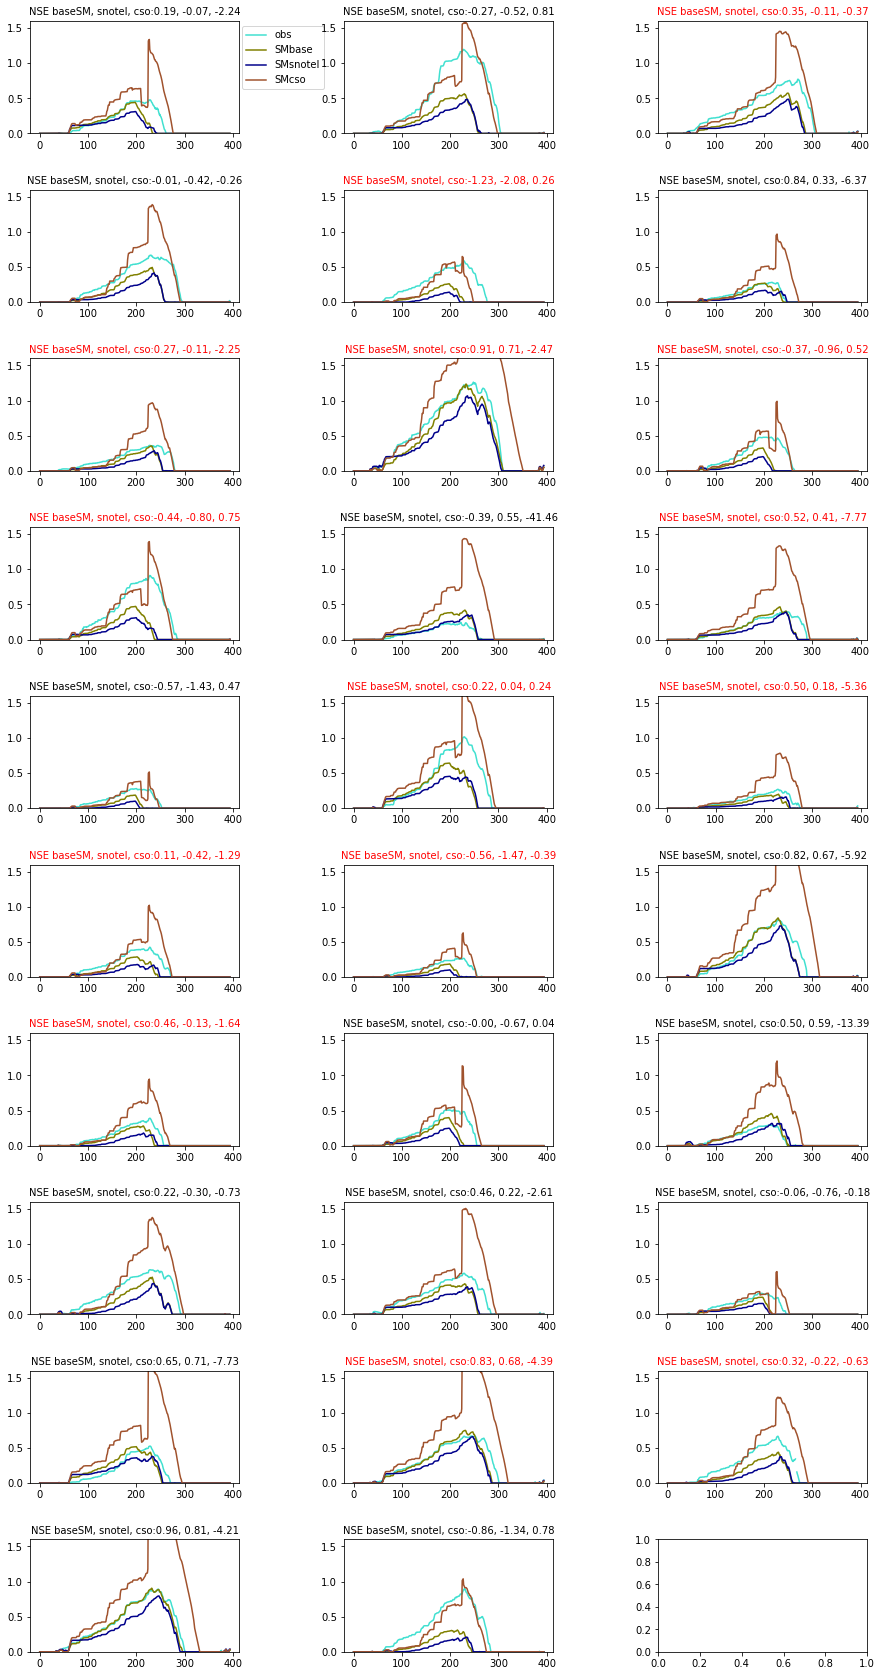

In [14]:
assim_stn = assim_gdf.code.values

#WY: nrows=10,figsize=(15, 30); 
#CA: nrows=8,figsize=(15, 24); 
#OR: nrows=4, figsize=(15, 15); 
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
fig, axs = plt.subplots(nrows=10,figsize=(15, 30), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.flatten()

for i in range(len(new)):
    x_idx = int(new.x_idx[i])
    y_idx = int(new.y_idx[i])
    nam = new.code[i]
    if any(nam in s for s in assim_stn):
        color = 'r'
    else:
        color = 'k'
    swe_mod_cso = np.squeeze(SMswe_cso[:,y_idx,x_idx])
    swe_mod_snotel = np.squeeze(SMswe_snotel[:,y_idx,x_idx])
    swe_mod_base = np.squeeze(SMswe_base[:,y_idx,x_idx])
    swe_obs = swe_snotel[nam]
    swe_stats_cso = calc_metrics(swe_mod_cso,swe_obs.values)
    swe_stats_snotel = calc_metrics(swe_mod_snotel,swe_obs.values)
    swe_stats_base = calc_metrics(swe_mod_base,swe_obs.values)
#     axs[i].text(1.3, .3, 'NSE_baseSM: '+str("{:.2f}".format(swe_stats_base[3]))+'\n'
#              +'NSE_snotel: '+str("{:.2f}".format(swe_stats_snotel[3]))+'\n'
#              +'NSE_cso: '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)
    axs[i].plot(swe_obs,label = 'obs', color = 'turquoise')
    axs[i].plot(swe_mod_base,label='mod_base',color = 'olive')
    axs[i].plot(swe_mod_snotel,label='mod_snotel',color = 'darkblue')
    axs[i].plot(swe_mod_cso,label='mod_cso',color = 'sienna')
    axs[i].set_title('NSE baseSM, snotel, cso:'+str("{:.2f}".format(swe_stats_base[3]))
             +', '+str("{:.2f}".format(swe_stats_snotel[3]))
             +', '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)
    axs[i].set_ylim([0, 1.6])
    if i == 0:
        axs[i].legend(['obs', 'SMbase','SMsnotel','SMcso'],bbox_to_anchor=(.99, 1), loc='upper left',)  
    

In [21]:
fig.savefig('assimcurves.pdf', format='pdf', dpi=300)

## bias

In [28]:
def calc_bias(mod_swe,stn_swe):

    #remove days with zero SWE at BOTH the station and the SM pixel
    idx = np.where((stn_swe != 0) | (mod_swe != 0))
    mod_swe = mod_swe[idx]
    stn_swe = stn_swe[idx]

    #remove days where station has nan values 
    idx = np.where(~np.isnan(stn_swe))
    mod_swe = mod_swe[idx]
    stn_swe = stn_swe[idx]
    
    #calculate bias
    bias = mod_swe-stn_swe
    bias = bias.tolist()
    
    return bias

In [30]:
i=1
x_idx = int(new.y_idx[i])
y_idx = int(new.x_idx[i])
nam = new.code[i]
swe_mod_cso = np.squeeze(SMswe_cso[:,y_idx,x_idx])/10
swe_stats_cso = calc_bias(swe_mod_cso,swe_obs.values)
plt.hist(swe_stats_cso)

IndexError: index 2382 is out of bounds for axis 2 with size 1382

In [27]:
from matplotlib.ticker import PercentFormatter
bias_base =[]
bias_cso =[]
bias_snotel=[]
nbins = 100
for i in range(len(new)):
    x_idx = int(new.est_idx[i])
    y_idx = int(new.nor_idx[i])
    nam = new.code[i]
    swe_mod_cso = np.squeeze(SMswe_cso[:,y_idx,x_idx])/10
    swe_mod_snotel = np.squeeze(SMswe_snotel[:,y_idx,x_idx])
    swe_mod_base = np.squeeze(SMswe_base[:,y_idx,x_idx])

    swe_obs = swe_snotel[nam]
    cso = calc_bias(swe_mod_cso,swe_obs.values)
    bias_cso.extend(calc_bias(swe_mod_cso,swe_obs.values))
    bias_snotel.extend(calc_bias(swe_mod_snotel,swe_obs.values))
    bias_base.extend(calc_bias(swe_mod_base,swe_obs.values))
fig, axs = plt.subplots(1, tight_layout=True)    
axs.hist(bias_base,bins=nbins,label='mod_base',color = 'olive',alpha=.5)#,density=True)
axs.hist(bias_cso,bins=nbins,label='mod_cso',color = 'sienna',alpha=.5)
axs.hist(bias_snotel,bins=nbins,label='mod_snotel',color = 'darkblue',alpha=.5)
#axs.yaxis.set_major_formatter(PercentFormatter(xmax=1))
axs.legend()

AttributeError: 'GeoDataFrame' object has no attribute 'est_idx'

In [ ]:
path = figpath+'wy19_assim_bias.pdf'
fig.savefig(path, format='pdf', dpi=300)

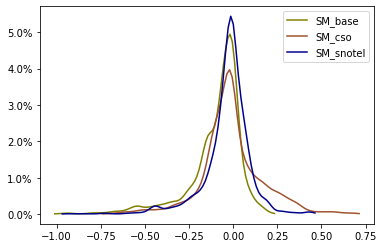

In [17]:
from scipy import stats

fig, axs = plt.subplots(1)  
data = np.array(bias_base)
kde = stats.gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
p = kde(x)

axs.plot(x,p,color = 'olive',label='SM_base')

data = np.array(bias_cso)
kde = stats.gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
p = kde(x)

axs.plot(x,p,color = 'sienna',label='SM_cso')

data = np.array(bias_snotel)
kde = stats.gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
p = kde(x)

axs.plot(x,p,color = 'darkblue',label='SM_snotel')

axs.yaxis.set_major_formatter(PercentFormatter(xmax=100))

plt.legend()

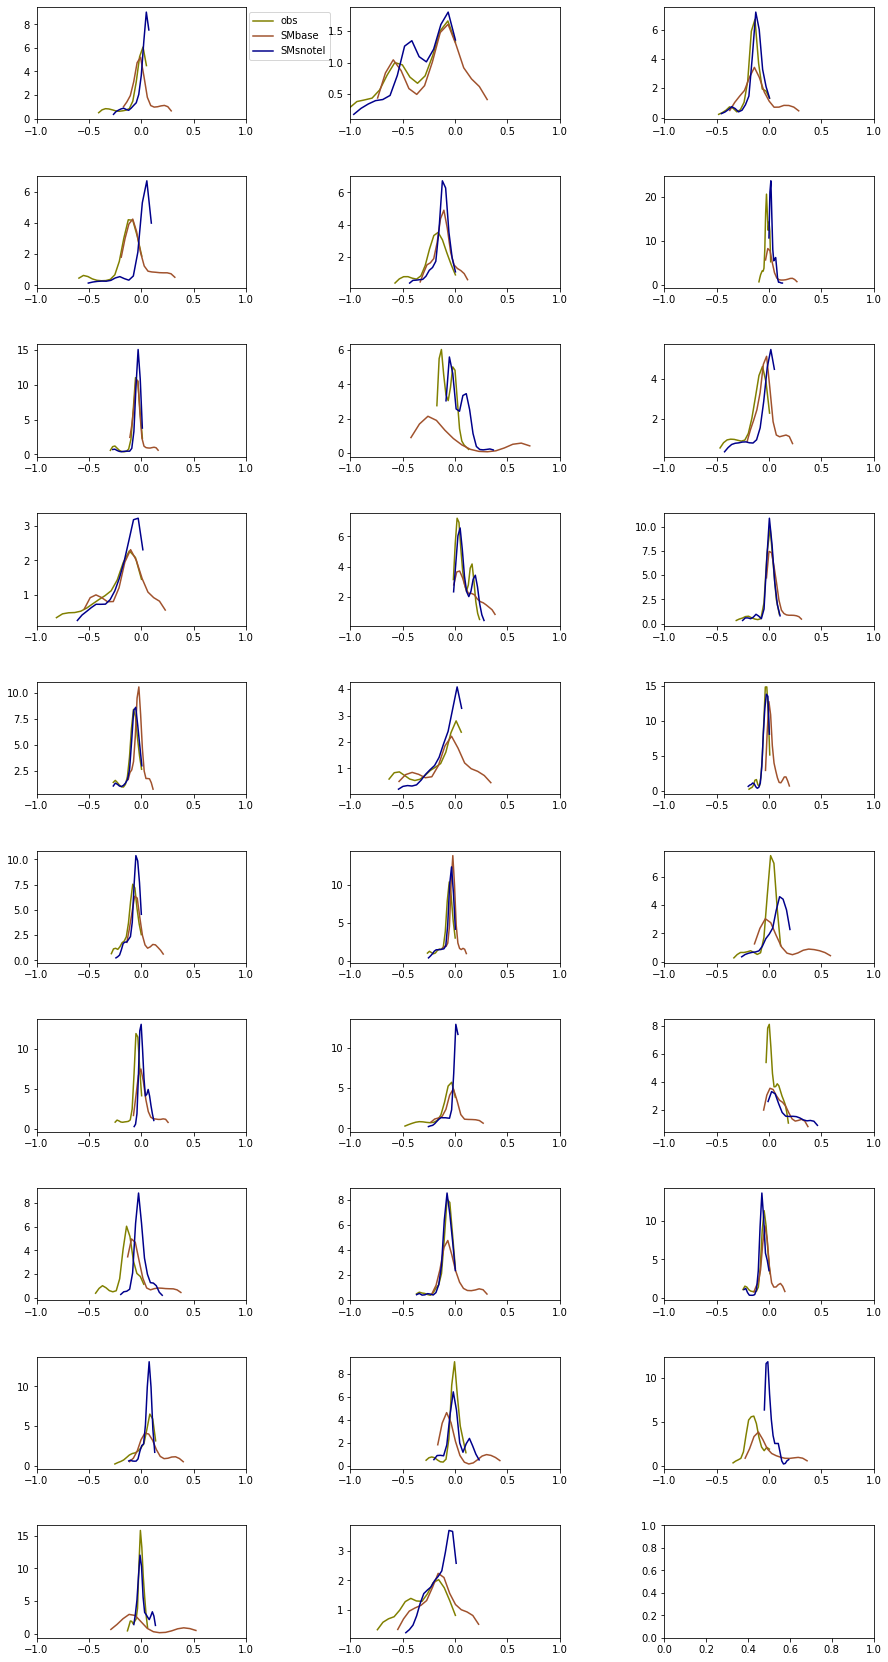

In [18]:
nbins = 20
fig, axs = plt.subplots(nrows=10,figsize=(15, 30), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.flatten()

for i in range(len(new)):
    x_idx = int(new.est_idx[i])
    y_idx = int(new.nor_idx[i])
    nam = new.code[i]
    swe_mod_cso = np.squeeze(SMswe_cso[:,y_idx,x_idx])/10
    swe_mod_snotel = np.squeeze(SMswe_snotel[:,y_idx,x_idx])
    swe_mod_base = np.squeeze(SMswe_base[:,y_idx,x_idx])

    swe_obs = swe_snotel[nam]
    swe_stats_cso = calc_bias(swe_mod_cso,swe_obs.values)
    swe_stats_snotel = calc_bias(swe_mod_snotel,swe_obs.values)
    swe_stats_base = calc_bias(swe_mod_base,swe_obs.values)
    
    data = np.array(swe_stats_base)
    kde = stats.gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 15)
    p = kde(x)

    axs[i].plot(x,p,color = 'olive',label='SM_base')

    data = np.array(swe_stats_cso)
    kde = stats.gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 15)
    p = kde(x)

    axs[i].plot(x,p,color = 'sienna',label='SM_cso')

    data = np.array(swe_stats_snotel)
    kde = stats.gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 15)
    p = kde(x)

    axs[i].plot(x,p,color = 'darkblue',label='SM_snotel')
    axs[i].set_xlim([-1, 1])
    if i == 0:
        axs[i].legend(['obs', 'SMbase','SMsnotel','SMcso'],bbox_to_anchor=(.99, 1), loc='upper left')  

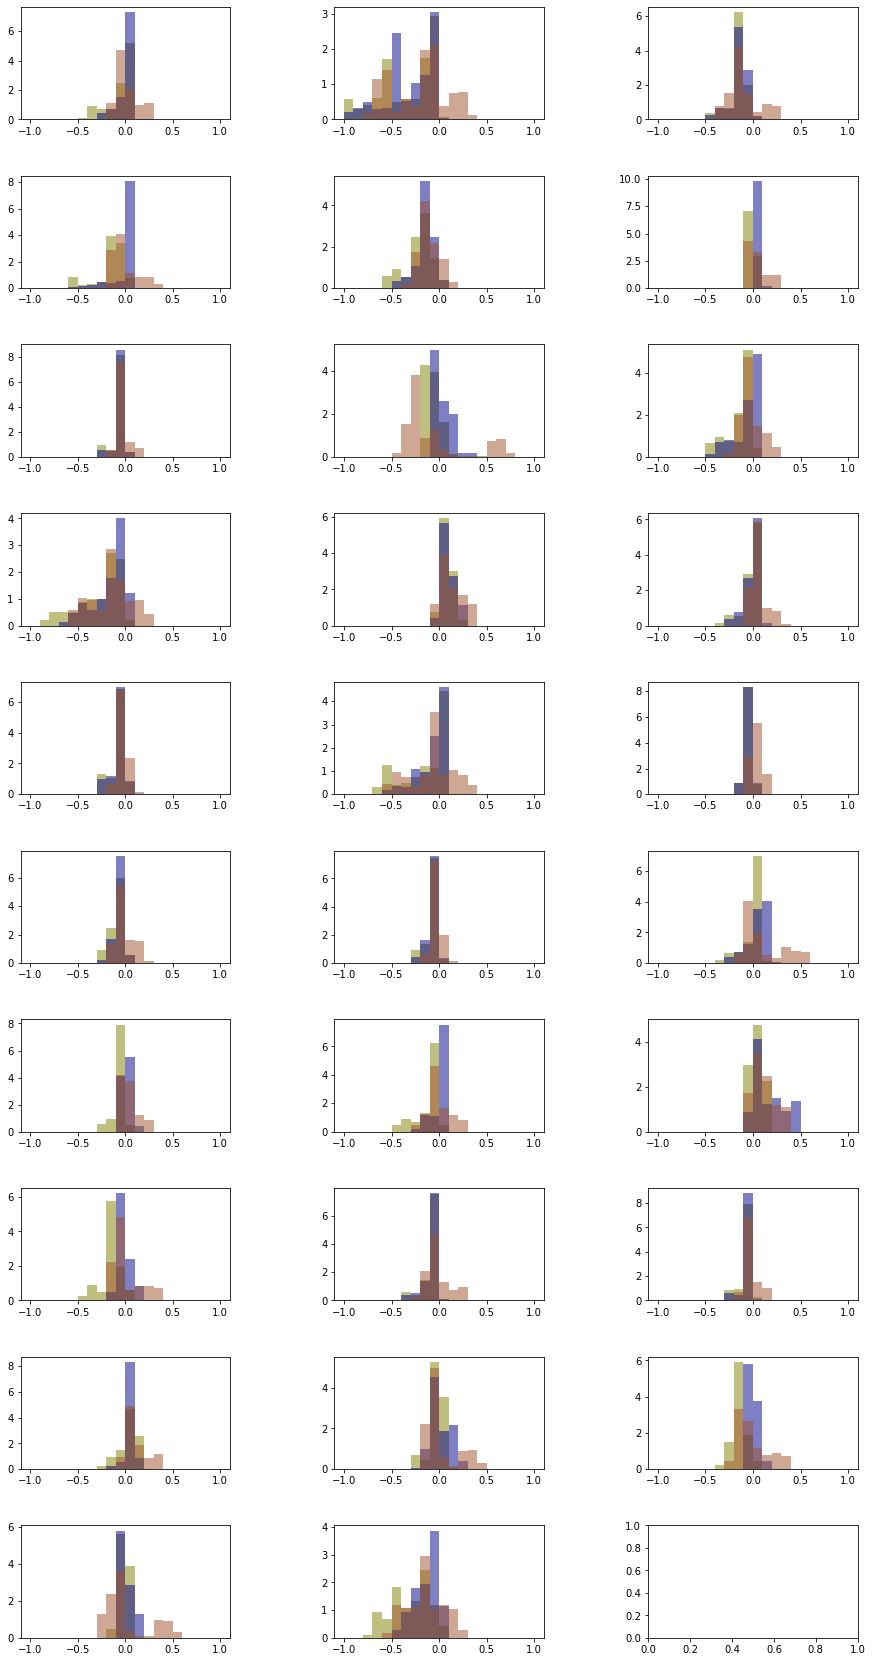

In [271]:
nbins = 20
fig, axs = plt.subplots(nrows=10,figsize=(15, 30), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.flatten()

for i in range(len(new)):
    x_idx = int(new.est_idx[i])
    y_idx = int(new.nor_idx[i])
    nam = new.code[i]
    swe_mod_cso = np.squeeze(SMswe_cso[:,y_idx,x_idx])/10
    swe_mod_snotel = np.squeeze(SMswe_snotel[:,y_idx,x_idx])
    swe_mod_base = np.squeeze(SMswe_base[:,y_idx,x_idx])

    swe_obs = swe_snotel[nam]
    swe_stats_cso = calc_bias(swe_mod_cso,swe_obs.values)
    swe_stats_snotel = calc_bias(swe_mod_snotel,swe_obs.values)
    swe_stats_base = calc_bias(swe_mod_base,swe_obs.values)
    #     axs[i].text(1.3, .3, 'NSE_baseSM: '+str("{:.2f}".format(swe_stats_base[3]))+'\n'
    #              +'NSE_snotel: '+str("{:.2f}".format(swe_stats_snotel[3]))+'\n'
    #              +'NSE_cso: '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)

    #axs[i].plot(swe_obs,label = 'obs', color = 'turquoise')
    axs[i].hist(swe_stats_base,bins=nbins,label='mod_base',color = 'olive',alpha=.5,density=True,range=[-1, 1])
    axs[i].hist(swe_stats_snotel,bins=nbins,label='mod_snotel',color = 'darkblue',alpha=.5,density=True,range=[-1, 1])
    axs[i].hist(swe_stats_cso,bins=nbins,label='mod_cso',color = 'sienna',alpha=.5,density=True,range=[-1, 1])

In [19]:
# extract swe time series at each station index from binary 
# build dataframe of this 
#compute performance metrics 
assim_stn = assim_gdf.code.values

i = 6
x_idx = new.est_idx[i]
y_idx = new.nor_idx[i]
nam = new.code[i]
if any(nam in s for s in assim_stn):
    color = 'r'
else:
    color = 'k'
swe_mod_cso = np.squeeze(SMswe_cso[:,y_idx,x_idx])/10
swe_mod_snotel = np.squeeze(SMswe_snotel[:,y_idx,x_idx])
swe_mod_base = np.squeeze(SMswe_base[:,y_idx,x_idx])
swe_stats_cso = calc_metrics(swe_mod_cso,swe_obs.values)
swe_stats_snotel = calc_metrics(swe_mod_snotel,swe_obs.values)
swe_stats_base = calc_metrics(swe_mod_base,swe_obs.values)
swe_obs = swe_snotel[nam]
plt.text(1.1, .3, 'NSE_baseSM: '+str("{:.2f}".format(swe_stats_base[3]))+'\n'
         +'NSE_snotel: '+str("{:.2f}".format(swe_stats_snotel[3]))+'\n'
         +'NSE_cso: '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)
plt.plot(swe_obs,label = 'obs', color = 'turquoise')
plt.plot(swe_mod_base,label='mod_base',color = 'olive')
plt.plot(swe_mod_cso,label='mod_cso',color = 'sienna')
plt.plot(swe_mod_snotel,label='mod_snotel',color = 'darkblue')
plt.legend()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

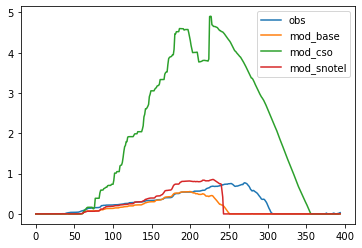

In [90]:
#old - only incorporates station data 
# extract swe time series at each station index from binary 
# build dataframe of this 
#compute performance metrics 
i = 1
x_idx = new.est_idx[i]
y_idx = new.nor_idx[i]
nam = new.code[i]
swe_mod_cso = np.squeeze(SMswe_cso[:,x_idx,y_idx])
swe_mod_snotel = np.squeeze(SMswe_snotel[:,x_idx,y_idx])
swe_mod_base = np.squeeze(SMswe_base[:,x_idx,y_idx])
swe_obs = swe_snotel[nam]
plt.plot(swe_obs,label = 'obs')
plt.plot(swe_mod_base,label='mod_base')
plt.plot(swe_mod_cso,label='mod_cso')
plt.plot(swe_mod_snotel,label='mod_snotel')
plt.legend()

# Loop Assim

In [12]:
from os import listdir
from os.path import isfile, join
mypath = assimPath+'assim2020-12-15/'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files

['M_1_swed.gdat',
 'elev_2_swed.gdat',
 'M_11_swed.gdat',
 'elev_1_swed.gdat',
 'M_3_swed.gdat',
 'M_2_swed.gdat',
 'elev_3_swed.gdat',
 'M_4_swed.gdat',
 'elev_0_swed.gdat']

In [6]:
files[0][0:-5]

'tc_1_swed'

In [13]:
SMswe_base = get_mod_output(swe_base,num_timesteps,ny,nx)
M_1 = get_mod_output(mypath+files[0],num_timesteps,ny,nx)
M_2 = get_mod_output(mypath+files[5],num_timesteps,ny,nx)
M_3 = get_mod_output(mypath+files[4],num_timesteps,ny,nx)
M_4 = get_mod_output(mypath+files[7],num_timesteps,ny,nx)
#M_3 = get_mod_output(mypath+files[2],num_timesteps,ny,nx)

MemoryError: Unable to allocate 5.04 GiB for an array with shape (1351623640,) and data type float32

In [24]:
M_1 = get_mod_output(mypath+files[0],num_timesteps,ny,nx)
M_2 = get_mod_output(mypath+files[4],num_timesteps,ny,nx)
M_3 = get_mod_output(mypath+files[3],num_timesteps,ny,nx)
elev_0 = get_mod_output(mypath+files[5],num_timesteps,ny,nx)
elev_1 = get_mod_output(mypath+files[2],num_timesteps,ny,nx)
elev_2 = get_mod_output(mypath+files[1],num_timesteps,ny,nx)


In [18]:
SMswe_base = get_mod_output(swe_base,num_timesteps,ny,nx)

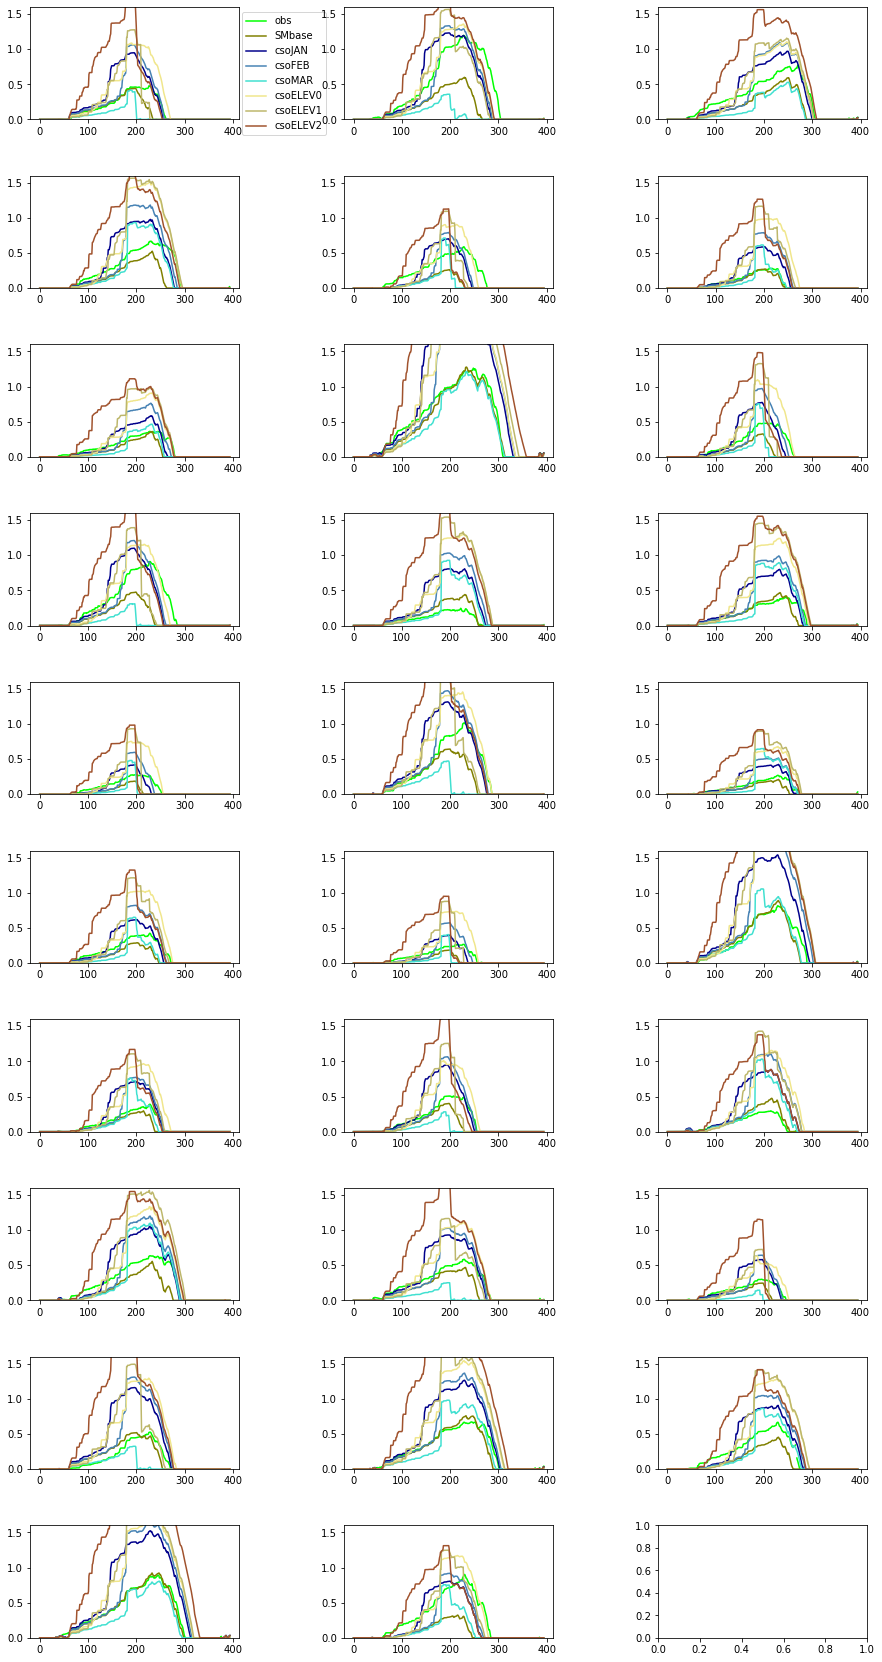

In [25]:
assim_stn = assim_gdf.code.values

#WY: nrows=10,figsize=(15, 30); 
#CA: nrows=8,figsize=(15, 24); 
#OR: nrows=4, figsize=(15, 15); 
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
fig, axs = plt.subplots(nrows=10,figsize=(15, 30), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.flatten()

for i in range(len(new)):
    x_idx = int(new.x_idx[i])
    y_idx = int(new.y_idx[i])
    nam = new.code[i]
    if any(nam in s for s in assim_stn):
        color = 'r'
    else:
        color = 'k'
    swe_mod_M_1 = np.squeeze(M_1[:,y_idx,x_idx])
    swe_mod_M_2 = np.squeeze(M_2[:,y_idx,x_idx])
    swe_mod_M_3 = np.squeeze(M_3[:,y_idx,x_idx])   
    swe_mod_elev_0 = np.squeeze(elev_0[:,y_idx,x_idx]) 
    swe_mod_elev_1 = np.squeeze(elev_1[:,y_idx,x_idx])
    swe_mod_elev_2 = np.squeeze(elev_2[:,y_idx,x_idx])    
    swe_mod_base = np.squeeze(SMswe_base[:,y_idx,x_idx])
    swe_obs = swe_snotel[nam]
    swe_stats_M_1 = calc_metrics(swe_mod_M_1,swe_obs.values)
    swe_stats_M_2 = calc_metrics(swe_mod_M_2,swe_obs.values)
    swe_stats_M_3 = calc_metrics(swe_mod_M_3,swe_obs.values)
    swe_stats_elev_0 = calc_metrics(swe_mod_elev_0,swe_obs.values)
    swe_stats_elev_1 = calc_metrics(swe_mod_elev_1,swe_obs.values)
    swe_stats_elev_2 = calc_metrics(swe_mod_elev_2,swe_obs.values)
    swe_stats_base = calc_metrics(swe_mod_base,swe_obs.values)
#     axs[i].text(1.3, .3, 'NSE_baseSM: '+str("{:.2f}".format(swe_stats_base[3]))+'\n'
#              +'NSE_snotel: '+str("{:.2f}".format(swe_stats_snotel[3]))+'\n'
#              +'NSE_cso: '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)
    axs[i].plot(swe_obs,label = 'obs', color = 'lime')
    axs[i].plot(swe_mod_base,label='mod_base',color = 'olive')
    axs[i].plot(swe_mod_M_1,label='mod_M_1',color = 'darkblue')
    axs[i].plot(swe_mod_M_2,label='mod_M_2',color = 'steelblue')
    axs[i].plot(swe_mod_M_3,label='mod_M_3',color = 'turquoise')
    axs[i].plot(swe_mod_elev_0,label='mod_elev_0',color = 'khaki')
    axs[i].plot(swe_mod_elev_1,label='mod_elev_1',color = 'darkkhaki') 
    axs[i].plot(swe_mod_elev_2,label='mod_elev_2',color = 'sienna')
#     axs[i].set_title('NSE baseSM, snotel, cso:'+str("{:.2f}".format(swe_stats_base[3]))
#              +', '+str("{:.2f}".format(swe_stats_snotel[3]))
#              +', '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)
    axs[i].set_ylim([0, 1.6])
    if i == 0:
        axs[i].legend(['obs', 'SMbase','csoJAN','csoFEB','csoMAR','csoELEV0','csoELEV1','csoELEV2'],bbox_to_anchor=(.99, 1), loc='upper left',)  
    

In [ ]:
assim_stn = assim_gdf.code.values

#WY: nrows=10,figsize=(15, 30); 
#CA: nrows=8,figsize=(15, 24); 
#OR: nrows=4, figsize=(15, 15); 
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
fig, axs = plt.subplots(nrows=10,figsize=(15, 30), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.flatten()

for i in range(len(new)):
    x_idx = int(new.x_idx[i])
    y_idx = int(new.y_idx[i])
    nam = new.code[i]
    if any(nam in s for s in assim_stn):
        color = 'r'
    else:
        color = 'k'
    swe_mod_M_1 = np.squeeze(M_1[:,y_idx,x_idx])
    swe_mod_M_2 = np.squeeze(M_2[:,y_idx,x_idx])
    swe_mod_M_3 = np.squeeze(M_3[:,y_idx,x_idx]) 
    swe_mod_M_4 = np.squeeze(M_4[:,y_idx,x_idx]) 
    swe_mod_base = np.squeeze(SMswe_base[:,y_idx,x_idx])
    swe_obs = swe_snotel[nam]
    swe_stats_M_1 = calc_metrics(swe_mod_M_1,swe_obs.values)
    swe_stats_M_2 = calc_metrics(swe_mod_M_2,swe_obs.values)
    swe_stats_M_3 = calc_metrics(swe_mod_M_3,swe_obs.values)
    swe_stats_M_4 = calc_metrics(swe_mod_M_4,swe_obs.values)
    swe_stats_base = calc_metrics(swe_mod_base,swe_obs.values)
#     axs[i].text(1.3, .3, 'NSE_baseSM: '+str("{:.2f}".format(swe_stats_base[3]))+'\n'
#              +'NSE_snotel: '+str("{:.2f}".format(swe_stats_snotel[3]))+'\n'
#              +'NSE_cso: '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)
    axs[i].plot(swe_obs,label = 'obs', color = 'turquoise')
    axs[i].plot(swe_mod_base,label='mod_base',color = 'olive')
    axs[i].plot(swe_mod_M_1,label='mod_M_1',color = 'darkblue')
    axs[i].plot(swe_mod_M_2,label='mod_M_2',color = 'sienna')
    axs[i].plot(swe_mod_M_3,label='mod_M_3',color = 'darkkhaki')
#    axs[i].plot(swe_mod_M_4,label='mod_M_4',color = 'steelblue')
#     axs[i].set_title('NSE baseSM, snotel, cso:'+str("{:.2f}".format(swe_stats_base[3]))
#              +', '+str("{:.2f}".format(swe_stats_snotel[3]))
#              +', '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)
    axs[i].set_ylim([0, 1.6])
    if i == 0:
        axs[i].legend(['obs', 'SMbase','csoJAN','csoFEB','csoMAR','csoAPR'],bbox_to_anchor=(.99, 1), loc='upper left',)  
    

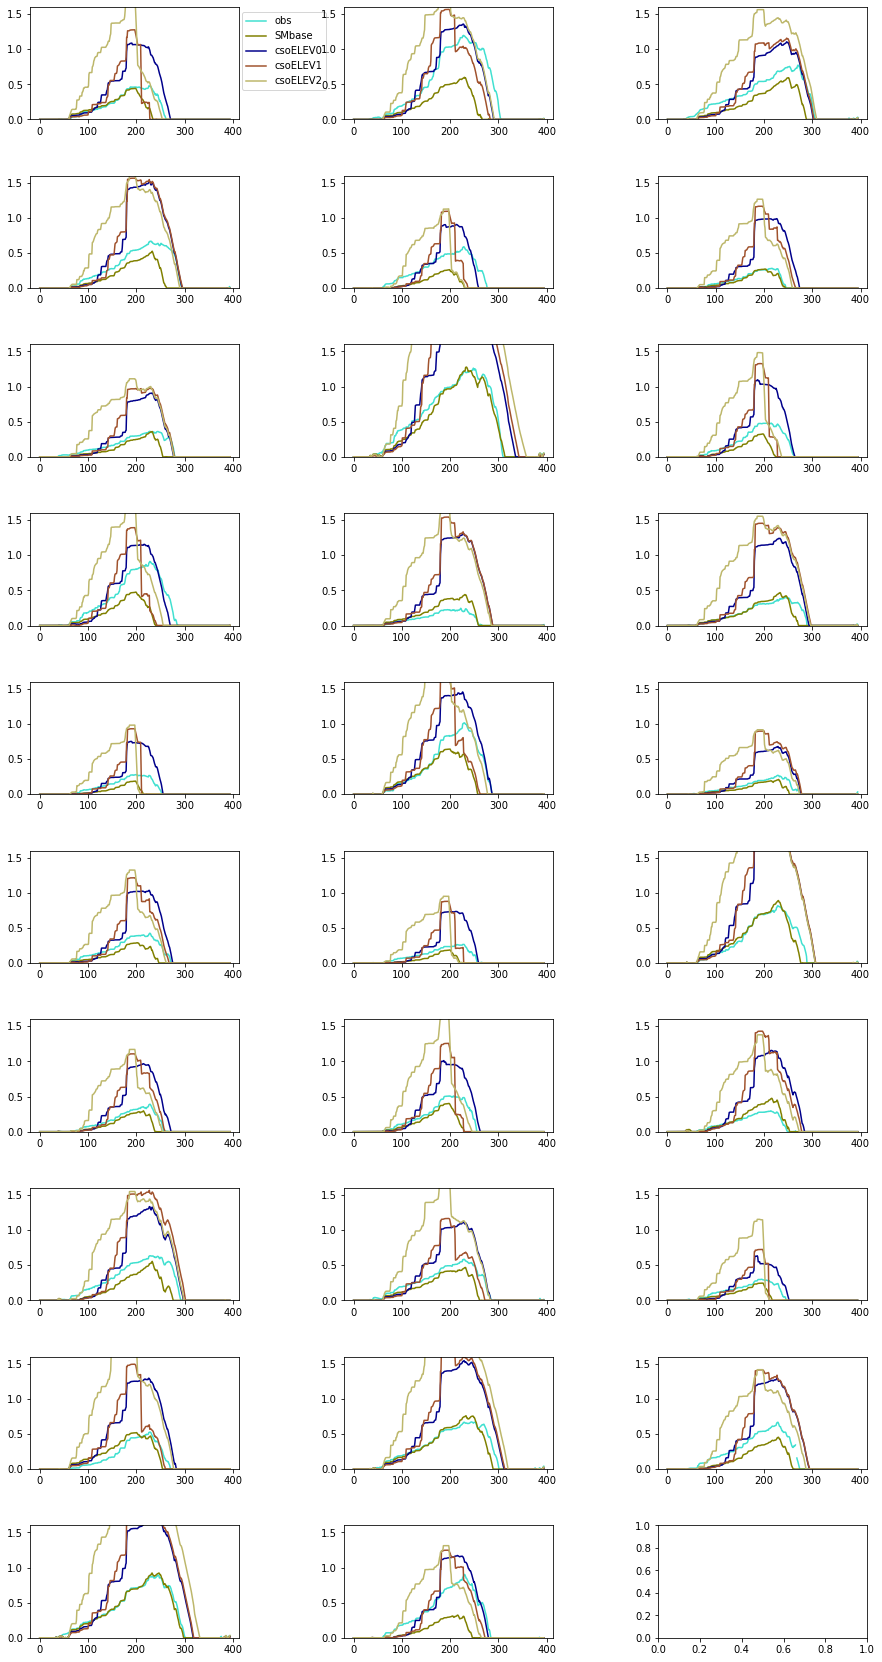

In [27]:
assim_stn = assim_gdf.code.values

#WY: nrows=10,figsize=(15, 30); 
#CA: nrows=8,figsize=(15, 24); 
#OR: nrows=4, figsize=(15, 15); 
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
fig, axs = plt.subplots(nrows=10,figsize=(15, 30), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.flatten()

for i in range(len(new)):
    x_idx = int(new.x_idx[i])
    y_idx = int(new.y_idx[i])
    nam = new.code[i]
    if any(nam in s for s in assim_stn):
        color = 'r'
    else:
        color = 'k'
  
    swe_mod_elev_0 = np.squeeze(elev_0[:,y_idx,x_idx]) 
    swe_mod_elev_1 = np.squeeze(elev_1[:,y_idx,x_idx])
    swe_mod_elev_2 = np.squeeze(elev_2[:,y_idx,x_idx])    
    swe_mod_elev_3 = np.squeeze(elev_2[:,y_idx,x_idx])    
    swe_mod_base = np.squeeze(SMswe_base[:,y_idx,x_idx])
    swe_obs = swe_snotel[nam]
    swe_stats_elev_0 = calc_metrics(swe_mod_elev_0,swe_obs.values)
    swe_stats_elev_1 = calc_metrics(swe_mod_elev_1,swe_obs.values)
    swe_stats_elev_2 = calc_metrics(swe_mod_elev_2,swe_obs.values)
    swe_stats_elev_3 = calc_metrics(swe_mod_elev_3,swe_obs.values)
    swe_stats_base = calc_metrics(swe_mod_base,swe_obs.values)
#     axs[i].text(1.3, .3, 'NSE_baseSM: '+str("{:.2f}".format(swe_stats_base[3]))+'\n'
#              +'NSE_snotel: '+str("{:.2f}".format(swe_stats_snotel[3]))+'\n'
#              +'NSE_cso: '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)
    axs[i].plot(swe_obs,label = 'obs', color = 'turquoise')
    axs[i].plot(swe_mod_base,label='mod_base',color = 'olive')
    axs[i].plot(swe_mod_elev_0,label='mod_elev_0',color = 'darkblue')
    axs[i].plot(swe_mod_elev_1,label='mod_elev_1',color = 'sienna') 
    axs[i].plot(swe_mod_elev_2,label='mod_elev_2',color = 'darkkhaki')
    axs[i].plot(swe_mod_elev_3,label='mod_elev_3',color = 'steelblue')
#     axs[i].set_title('NSE baseSM, snotel, cso:'+str("{:.2f}".format(swe_stats_base[3]))
#              +', '+str("{:.2f}".format(swe_stats_snotel[3]))
#              +', '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)
    axs[i].set_ylim([0, 1.6])
    if i == 0:
        axs[i].legend(['obs', 'SMbase','csoELEV0','csoELEV1','csoELEV2'],bbox_to_anchor=(.99, 1), loc='upper left',)  
    

In [14]:
#heatmap
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, vmin=-1, vmax=1, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
[]
axs[i].plot(swe_obs,label = 'obs', color = 'turquoise')
    axs[i].plot(swe_mod_base,label='mod_base',color = 'olive')
    axs[i].plot(swe_mod_snotel,label='mod_snotel',color = 'darkblue')
    axs[i].plot(swe_mod_cso,label='mod_cso',color = 'sienna')

In [ ]:
inar = [SMswe_base,SMswe_snotel,SMswe_cso]
data = np.zeroes([len(inar),len(new)])
i = 0 
swe_mod_base = np.squeeze(SMswe_base[:,new.y_idx[i],new.x_idx[i]])
swe_obs = swe_snotel[new.code[i]]
swe_stats = calc_metrics(swe_mod_base,swe_obs.values)
swe_stats

In [ ]:
Metrics = ['R2','MBE','RMSE','NSE','KGE']
Stations = gdf['code'].values

def func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")
#WA figsize=(8,16)
fig, ((ax), (ax1), (ax2), (ax3),(ax4)) = plt.subplots(5, 1, figsize=(12,16))

# Replicate the above example with a different font size and colormap.
im, cbar = heatmap(data.cal_metrics[top_params[0],:,:], Metrics, Stations, ax=ax,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax.set_title('Top run with metric ='+Metrics[0])

im, _ = heatmap(data.cal_metrics[top_params[1],:,:], Metrics, Stations, ax=ax1,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax1.set_title('Top run with metric ='+Metrics[1])

im, _ = heatmap(data.cal_metrics[top_params[2],:,:], Metrics, Stations, ax=ax2,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax2.set_title('Top run with metric ='+Metrics[2])

im, _ = heatmap(data.cal_metrics[top_params[3],:,:], Metrics, Stations, ax=ax3,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax3.set_title('Top run with metric ='+Metrics[3])

im, _ = heatmap(data.cal_metrics[top_params[4],:,:], Metrics, Stations, ax=ax4,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax4.set_title('Top run with metric ='+Metrics[4])


plt.tight_layout()
plt.show()